<div style="max-width:1200px"><img src="../_resources/mgnify_banner.png" width="100%"></div>

<img src="../_resources/mgnify_logo.png" width="200px">

[MGnifyR](http://github.com/beadyallen/mgnifyr) is a library that provides a set of tools for easily accessing and processing MGnify data in R, making queries to MGnify databases through the [MGnify API](https://www.ebi.ac.uk/metagenomics/api/v1/). 
The benefit of MGnifyR is that data can either be fetched in tsv format or be directly combined in a phyloseq object to run an analysis in a custom workflow.

This is an interactive code notebook (a Jupyter Notebook). To run this code, click into each cell and press the ▶ button in the top toolbar, or press shift+enter

# Metagenomics bioinformatics at MGnify 2023

## Comparative metagenomics (practical session)

### Normalization methods, alpha & beta diversity, and differentially abundant features

In this notebook we aim to demonstrate how the MGnifyR tool can be used to fetch data and metadata of a MGnify metagenomic analyisis. Then we show diversity metrics calculus and two methods to identify differentially abundant features using taxonomic and functional profiles.


## Contents
- [Part 1. Fetching data and preprocessing](#part1)
  - [1.1. Fetch the MGnify Analyses accession](#part1_1)
  - [1.2. Explore and filter samples by metadata](#part1_2)
  - [1.3. Converting into phyloseq object](#part1_3)
- [Part 2. Normalization, alpha diversity indices and taxonomic profiles visualization](#part2)
   - [2.1. Cleaning the OTUs matrix](#part2_1)
   - [2.2. Normalization by total sum scaling (TSS, relative abundance or proportions)](#part2_2)
   - [2.3. Normalization by subsampling (rarefaction)](#part2_3)
   - [2.4. Normalization by cumulative sum scaling (CSS)](#part2_4)
   - [2.5. Computing alpha diversity indices](#part2_5)
   - [2.6. Community profile visualization](#part2_6)
- [Part 3. Comparative metagenomics at community-level: Beta diversity](#part3)
- [Part 4. Detection of differentially abundant taxa](#part4)
    - [4.1. Association testing](#part4_1)
    - [4.2. Cofounder testing](#part4_2)
    - [4.3. Generation of a predictive model: Machine learning workflow](#part4_3)
- [References](#refs)

In [3]:
# Loading libraries:
suppressMessages({    
    library(ALDEx2)
    library(data.table)
    library(dplyr)
    library(ggplot2)
    library(IRdisplay)
    library(KEGGREST)
    library(metagenomeSeq)
    library(microbiomeMarker)
    library(MGnifyR)   
    library(pathview)
    library(phyloseq)
    library(plyr)
    library(SIAMCAT)
    library(stringr)
    library(tidyjson)
    library(tidyverse)
    library(vegan)
})

#display_markdown(file = 'assets/mgnifyr_help.md')

In [4]:
# Setting tables and figures size to display (these will be reset later):
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
options(repr.plot.width=4, repr.plot.height=4)

In [5]:
# Setting up functions
collect_pathways <- function(ids_list) {
    pathways = list()
    for (id in ids_list) { 
        current_pathway = as.list(keggLink("pathway", id))
        for (index in grep("map", current_pathway)) {        
            clean_id = gsub("*path:", "", current_pathway[index])
            # Discarding chemical structure (map010XX), global (map011XX), and overview (map012XX) maps
            prefix = substring(clean_id, 1, 6)
            if(is.na(match("map010", prefix)) & is.na(match("map011", prefix)) & is.na(match("map012", prefix)) ){
                pathways = append(pathways, clean_id)
            }
        }
    }
    return(pathways)
}

In [6]:
# Create your session mgnify_client object
mg = mgnify_client(usecache = T, cache_dir = '/home/jovyan/.mgnify_cache')

## Part 1. Fetching data and preprocessing <a id='part1'/>

In this example we are going to fetch MGnify analysis results and metadata for TARA ocean metagenomic study corresponding to size fractions for prokaryotes ([MGYS00002008](https://www.ebi.ac.uk/metagenomics/studies/MGYS00002008#overview)).
Find more information about the [TARA Ocean Project.](https://fondationtaraocean.org/en/expedition/tara-oceans/)

### 1.1. Fetch the MGnify Analyses accession <a id='part1_1'/>

1. The first step is to retrieve the analysis accession list and metadata.

In [7]:
tara_all = mgnify_analyses_from_studies(mg, 'MGYS00002008')
metadata = mgnify_get_analyses_metadata(mg, tara_all)

  |======================================================================| 100%
  |======================================================================| 100%


<div class="alert alert-block alert-info">
<b>Tip:</b> In case you are interested in running the comparative metagenomic analysis using data from different studies in MGnify, you can adapt the following commands:
</div>
 
    
```R
analyses_accessions = mgnify_analyses_from_studies(mg, c("MGYS1","MGYS2"))

metadata = mgnify_get_analyses_metadata(mg, analyses_accessions)
```

### 1.2. Explore and filter samples by metadata <a id='part1_2'/>

We want to keep only **metagenomic** samples (not amplicon) of 'surface water layer ([ENVO:00002042](https://www.ebi.ac.uk/ols/ontologies/envo/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FENVO_00002042))' and 'mesopelagic zone ([ENVO:00000213](https://www.ebi.ac.uk/ols/ontologies/envo/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FENVO_00000213))' to compare. We also want to filter out results generated with old pipeline versions (<[v5.0](https://www.ebi.ac.uk/metagenomics/pipelines/5.0)). In the following steps we will filter out other samples before exporting to the phyloseq object. Let's first explore the metadata we fetched:

1) Check the number of analyses in the study.

In [8]:
length(metadata$'analysis_accession')

[1] 497

2) Check the `analysis_experiment-type` to determine whether a filtering is necesary to discard amplicon samples.

In [9]:
unique(metadata$'analysis_experiment-type')

[1] "assembly"

3) Keep results generated only with the most updated pipeline (v5.0).

In [10]:
v5_metadata = metadata[which(metadata$'analysis_pipeline-version'=='5.0'), ]
length(v5_metadata$'analysis_accession')

#head(v5_metadata)

[1] 248

4) Check the `sample_environment-feature` to discover what kind of samples are part of the study and how many of each exists.

<div class="alert alert-block alert-info">
<b>Note:</b> For a comparative study, we need at least 5 samples per group
</div>

In [11]:
table(v5_metadata$'sample_environment-feature')


                                   deep chlorophyll maximum layer (ENVO:xxxxxxxx) 
                                                                               76 
                                   marine epipelagic mixed layer (ENVO:xxxxxxxxx) 
                                                                                9 
                                                 mesopelagic zone (ENVO:00000213) 
                                                                               43 
mesopelagic zone (ENVO:00000213) &amp; marine oxygen minimum zone (ENVO:01000065) 
                                                                               13 
                                              surface water (ENVO:00002042) layer 
                                                                                6 
                                              surface water layer (ENVO:00002042) 
                                                                              100 
   

Let's keep only samples having [ENVO:00002042](https://www.ebi.ac.uk/ols/ontologies/envo/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FENVO_00002042) or [ENVO:00000213](https://www.ebi.ac.uk/ols/ontologies/envo/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FENVO_00000213) in the `sample_environment-feature` column. We want to create a new dataframe containing the relevant samples.

We are also going to create a clean label for the environment feature.

<div class="alert alert-block alert-info">
<b>Note:</b> To speed up the following analysis, we are going to keep only 25 samples per group (by randomly subsampling the accessions)
</div>

In [12]:
# Saving the list of relevant samples in a dataframe
sub1 = v5_metadata[str_detect(v5_metadata$'sample_environment-feature', "ENVO:00002042"), ]
set.seed(345)
acc_s1 = sample(sub1$'analysis_accession', size=25, replace = FALSE)

sub2 = v5_metadata[str_detect(v5_metadata$'sample_environment-feature', "ENVO:00000213"), ]
set.seed(345)
acc_s2 = sample(sub2$'analysis_accession', size=25, replace = FALSE)

filtered_samples = c(acc_s1,acc_s2)

# To create the environment feature label:
env_label = c(rep('Surface', times=25), rep('Mesopelagic', times=25))

<div class="alert alert-block alert-warning">
<b>Up to you:</b> You can try to re-run the analysis with a different set of samples to compare for instance 'deep chlorophyll maximum layer' versus 'mesopelagic zone'. How would you change the code to filter in relevant samples? Could you used another column in the metadata table?
</div>

### 1.3. Converting into phyloseq object <a id='part1_3'/>

1. Now that we have a new dataframe with 50 samples from either surface or mesopelagic zone water, we are going to create the phyloseq object

In [15]:
ps = mgnify_get_analyses_phyloseq(mg, filtered_samples)

  |======================================================================| 100%


2. Keep only relevant columns in metadata table and transform numeric variables from characters to numbers. Add the environment label as well.

In [17]:
#sample_variables(ps)

# Keeping relevant metadata only
variables_to_keep = c('sample_temperature','sample_depth','sample_salinity','sample_chlorophyll.sensor','sample_nitrate.sensor','sample_oxygen.sensor')

df = data.frame(sample_data(ps))[variables_to_keep]

# Transforming character to nummeric variables
df[] = lapply(df, function(x) as.numeric(as.character(x)))

sample_data(ps) = df

# Adding the env label                              
sample_data(ps)$'env_feature' = env_label

#sample_data(ps)

## Part 2. Normalization, alpha diversity indices and taxonomic profiles visualization <a id='part2'/>

### 2.1. Cleaning the OTUs matrix <a id='part2_1'/>

1) Remove samples with extremely low coverage – they aren't informative and interfere with the normalization process. The first step is to detect outliers by plotting some histograms.

In [ ]:
ps

options(repr.plot.width=4, repr.plot.height=4)

hist(log10(sample_sums(ps)), breaks=50, main="Sample size distribution", xlab="Sample size (log10)", ylab="Frequency", col="#007c80")


We can see that samples with number of reads $\leq 10 ^ {1.5}$ (i.e. $\lesssim 32$) seem to be outliers. 
   Let's filter out the outliers and plot a new histogram.

In [ ]:
ps_good = subset_samples(ps, sample_sums(ps) > 32)

hist(log10(sample_sums(ps_good)), breaks=50, main="Sample size distribution", xlab="Sample size (log10)", ylab="Frequency", col="#007c80")


2) Remove singletons. Singletons are OTUs of size one, meaning that only one read was assigned to that OTU. These very low-abundance OTUs could be biologically real (belonging to the rare biosphere ([1](#reference_1))), or they could be false positives due to sequencing artefacts. Singletons observed in only one sample are more likely to be artefacts, and it is good practice to remove them from the OTUs counts table to avoid artificially over-estimating the OTUs richness. You can find more discussion about this in [Robert Edgar's blog](https://drive5.com/usearch/manual/singletons.html).

<div class="alert alert-block alert-warning">
<b>Question:</b> Is the low abundant portion of the microbial community (rare biosphere) biologically relevant? What would be a good approach to study this particular fraction of the microbial communities?
</div>

In [ ]:
ps_final = filter_taxa(ps_good, function(x) sum(x) > 1, prune=TRUE)


<div class="alert alert-block alert-warning">
<b>Up to you:</b> You can try to discard also doubletons or OTUs in size<=3. Is there any difference in the OTUs table?
</div>

3) Show some stats on the sequencing depth across samples.

In [ ]:
max_difference = max(sample_sums(ps_final))/min(sample_sums(ps_final))

sprintf("The max difference in sequencing depth is %s", max_difference)

options(repr.plot.width=4, repr.plot.height=5)

boxplot(sample_sums(ps_final), main="Sequencing depth across samples", xlab="", ylab="Number of reads", col="#a6093d")
text(y=boxplot.stats(sample_sums(ps_final))$stats, labels=boxplot.stats(sample_sums(ps_final))$stats, x=1.25)

An approximately 10-fold difference in the library sizes means that we will need to apply a normalization method before continuing with the analysis. The most common normalization methods used in microbiome count data are proportions and rarefaction. However, other methods originally developed to normalize RNA-seq counts have been adapted to differential-abundance analysis in microbiome data. A discussion about how to choose the right normalization method is out of the scope of this material, but the topic has been covered in multiple forums and scientific publications. Depending on the downstream analysis we intend to perform, different methods might be appropriate. For instance, to compare groups of samples at community-level through beta-diversity, "...proportions and rarefying produced more accurate comparisons among communities and are the only methods that fully normalized read depths across samples. Additionally, upper quartile, cumulative sum scaling (CSS), edgeR-TMM, and DESeq-VS often masked differences among communities when common OTUs differed, and they produced false positives when rare OTUs differed" ([2](#reference_2)). On the other hand, for detection of differentially abundant species, "both proportions and rarefied counts result in a high rate of false positives in tests for species that are differentially abundant across sample classes" ([3](#reference_3)).

In the following examples we will show three popular ways of normalization: relative abundance, rarefaction and cummulative sum scaling.

### 2.2. Normalization by total sum scaling (TSS, relative abundance or proportions) <a id='part2_2'/>

The simplest way to normalize the differences in sample size is to transform the OTU counts table into relative abundance by dividing by the number of total reads of each sample. This type of normalization is also referred to as relative abundance or proportions. We use this normalization to compare taxonomic profiles, while alpha diversity indices are computed on the non-normalized matrix. The reason to do so is that we need a matrix of integer numbers as input.

1) Transform taxonomy raw-counts matrix into relative abundance.  <a id='part2_2_2'/>

In [ ]:
relab_ps = transform_sample_counts(ps_final, function(x) x/sum(x))

2) Agglomerate taxonomy at Class rank and keep only the most abundant classes (threshold=1%, i.e. 0.01). In microbial data, we expect to observe abundance distributions with a long 'tail' of low-abundance organisms which often comprise the large majority of species. For this reason, once the matrix has been transformed to relative abundance, we will transform the taxonomic profile at a high taxonomic rank (Class), agglomerating the counts first and using an abundance threshold of 1% to avoid displaying too many unreadable categories in the plot.

In [ ]:
psglom = tax_glom(relab_ps, "Class")
top_tss_ps = filter_taxa(psglom, function(x) mean(x) > 0.01, TRUE)

### 2.3. Normalization by subsampling (rarefaction) <a id='part2_3'/>

Rarefaction is an alternative to relative abundance normalization to obtain an adjusted OTUs count matrix. The method is based on a process of subsampling to the smallest library size in the data set. The algorithm randomly removes reads until the samples reach the same library size. Despite the apparent disadvantage of discarding information from the larger samples, rarefaction is quite popular in microbial ecology. The first step is to find the smallest sample size. We can use the number of observed OTUs in the original matrix to do so.

1) Find the smallest sample size.

In [ ]:
df=as.data.frame(sample_sums(ps_final))
head(df[order( df[,1] ),],1)

2) Rarefying to the smallest sample.

In [ ]:
ps_rare = rarefy_even_depth(ps_final, sample.size=65, replace=FALSE, rngseed=123, verbose=FALSE)

#otu_table(ps_rare)

3) Aglomerate taxonomy at Class rank keeping the top 15 classes only.

In [ ]:
psglom = tax_glom(ps_rare, "Class")
top15 = names(sort(taxa_sums(psglom), decreasing=TRUE)[1:15])
top15_rare_ps = prune_taxa(top15, psglom)

### 2.4. Normalization by cumulative sum scaling (CSS) <a id='part2_4'/>

The third normalization method we are going to apply is CSS. To do so, we will use the implementation on the `microbiomeMarker` library.
Cumulative sum scaling normalization calculates scaling factors as the cumulative sum of gene (or taxa) abundances up to a data-derived threshold. This method is based on the assumption that the count distributions in each sample are equivalent for low abundance genes up to a certain threshold. Only the segment of each sample's count distribution that is relatively invariant across samples is scaled by CSS.

1) Normalizing the OTU counts in the `ps_final` object.

In [ ]:
ps_CSS = normalize(ps_final, method="CSS")

2) Aglomerate taxonomy at Class rank and keep the top 15 classes only.

In [ ]:
psglom = tax_glom(ps_CSS, "Class")
top15 = names(sort(taxa_sums(psglom), decreasing=TRUE)[1:15])
top15_css_ps = prune_taxa(top15, psglom)

### 2.5. Computing alpha diversity indices <a id='part2_5'/>

Alpha diversity is a measure of species diversity in a particular area or an ecosystem. In terms of microbial ecology, analyzing the sample diversity of sequencing data is commonly the first step in assessing differences between microbial environments. Some of the most popular alpha diversity indices reported in microbial community analyses are Chao1, abundance-based coverage estimators (ACE), Simpson, and Shannon-Weaver.  
Chao1 and ACE are nonparametric estimators that describe diversity as the max number of expected species in the sample (species richness). They consider the proportion of species that have been observed before ("recaptured") to those that are observed only once. Both Chao1 and ACE underestimate true richness at low sample sizes.  
On the other hand, Simpson and Shannon-Weaver, consider relative abundances and depends on both, species richness and the evenness (or equitableness), with which individuals are distributed among the different species. However, both metrics have specific biases. The Shannon-Weaver index places a greater weight on species richness, whereas the Simpson index considers evenness more than richness in its measurement.  
More discussion and examples illustrating how sample size and normalization methods can affect alpha diversity metrics in references [4](#reference_4) and [5](#reference_5).  
According to Pereira *et al.,* (2018)([7](#reference_7)), the best normalization method for metagenomic gene abundance (tested in TARA ocean samples) is CSS for large group sizes. For this reason, we will use this method to show alpha and beta-diversity analyses. 

In [ ]:
options(repr.plot.width=12, repr.plot.height=3)

plot_richness(ps_CSS, x="env_feature", color="env_feature", title="Cumulative sum scaling", measures=c("Observed", "Chao1", "ACE", "Shannon", "Simpson")) + 
    geom_boxplot() + 
    theme_bw() + 
    scale_color_manual(values=c("#0a5032", "#a1be1f")) + 
    labs(x='', color="Environment")


<div class="alert alert-block alert-warning">
<b>Question:</b> Which normalization method affects more the diversity metrics? Could you say only comparing the plots, which normalization method is the best for this dataset?
</div>

### 2.6. Community profile visualization <a id='part2_6'/>

Visualise the taxonomic profile in barplots at Class rank in two modes.

In [ ]:
options(repr.plot.width=10, repr.plot.height=4)

plot_bar(top15_css_ps, fill="Class", title="Cumulative sum scaling") + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.background=element_rect(fill=NA), panel.grid.major=element_line(colour="#ebebeb")) + 
    labs(x=NULL)

<div class="alert alert-block alert-warning">
<b>Question:</b> Which normalization method affects more the taxonomic profile? Could you say only comparing the plots, which normalization method is the best for this dataset?
</div>

By naked eye, we can see that the profiles looks quite different. Let's take a deeper look at some interesting Classes to check how the abundance change depending on the normalization method.

In [ ]:
options(repr.plot.width=12, repr.plot.height=2)

plot_bar(subset_taxa(top15_css_ps, Class=='Alphaproteobacteria' | Class=='Dinophyceae' | Class=='Thermoplasmata' ), fill="Class", title="Cumulative sum scaling") + 
    facet_wrap(~Class) + 
    scale_fill_manual(values=c("#18974c","#d41645","#f49e17")) +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.background=element_rect(fill=NA), panel.grid.major=element_line(colour="#ebebeb")) + 
    labs(x=NULL)

<div class="alert alert-block alert-warning">
<b>Question:</b> What is the main risk of using rarefaction as normalization method?
</div>

## Part 3. Comparative metagenomics at community-level: Beta diversity <a id='part3'/>

Beta (β)-diversity is used in ecology to assess the heterogeneity of local communities. It is defined as the ratio between regional and local species diversity. In simpler terms, it calculates the number of species that are not the same in two different environments. 

Some of the most popular beta diversity measures in microbiome research include Bray-Curtis index (for compositional data), Jaccard index (for presence/absence data, ignoring abundance information), Aitchison distance (Euclidean distance for transformed abundances, aiming to avoid the compositionality bias), and the Unifrac distances (that use the phylogenetic tree information). Only some of the commonly used beta diversity measures are actual distances, therefore, the term dissimilarity or beta-diversity is commonly used. The workflow to assess β-diversity between groups of samples starts with calculating the diversity indices for each pair of samples. This results in a distance (or dissimilarity) matrix that is often used for ordination (e.g., principal coordinates analysis) and data exploration in microbiota data analysis ([6](#reference_6)).

For statistical analysis, [adonis](https://www.rdocumentation.org/packages/vegan/versions/2.6-4/topics/adonis) and [betadisper](https://www.rdocumentation.org/packages/vegan/versions/2.6-4/topics/betadisper) methods are widely used together in β-diversity analyses. 

Adonis tests whether two or more groups have different compositions. Adonis calculates the squared deviations of each site to the centroid and then, performs significance tests using F-tests based on sequential sums of squares from permutations of the raw data. It can be seen as an ANOVA using distance matrices (analogous to MANOVA). A non significant p-value (p>0.05), means that there's no difference in **composition** between groups (null hypothesis of no difference in composition between groups).

Betadisper tests if two or more groups are homogeneously dispersed in relation to their species in studied samples. This test can be done to see if one group has more compositional variance than another. The method use the distance matrix to calculate the multivariate dispersions (variances; average distance to centroids). Then we use group dispersions to perform an ANOVA test. ANOVA's p-value not significant (p>0.05) means that group **dispersions** are homogenous (null hypothesis of no difference in dispersion between groups).


1) Compute beta diversity using various methods to calculate distance, and perform principle components analysis ploting the first two axes. 

According to Pereira *et al.,* (2018)([7](#reference_7)), the best normalization method for metagenomic gene abundance (tested in TARA ocean samples) is CSS for large group sizes. For this reason, we will use this method to show beta-diversity. Then, using as a guide the steps described in ([8](#reference_8)), we will create a list of suitable distance methods, iterate through them, and display a combined plot. For a better visualization we are going to show the 95% confidence region with an ellipse.

In [ ]:
# Generating the methods list and discarding those that are not included in adonis methods list
dist_methods = unlist(distanceMethodList)
dist_methods = dist_methods[c(-(1:4),-(20:47))]

# Iterating through the list and save the plots
plist = vector("list", length(dist_methods))
names(plist) = dist_methods
for( i in dist_methods ){
    # Calculate distance matrix
    iDist = distance(ps_CSS, method=i)
    # Calculate ordination
    iMDS  = ordinate(ps_CSS, "MDS", distance=iDist)
    ## Make plot
    # Don't carry over previous plot (if error, p will be blank)
    p = NULL
    # Create plot, store as temp variable, p
    p = plot_ordination(ps_CSS, iMDS, color="env_feature")
    # Add title to each plot
    p = p + ggtitle(paste("MDS using distance method ", i, sep=""))
    # Save the graphic to file.
    plist[[i]] = p
}

# Create a combined plot
df = ldply(plist, function(x) x$data)
names(df)[1] = "distance"
p = ggplot(df, aes(Axis.1, Axis.2, color=env_feature))
p = p + geom_point(size=3, alpha=0.5)
p = p + facet_wrap(~distance, scales="free")
p = p + ggtitle("MDS on various distance metrics for TARA ocean dataset") + 
    stat_ellipse(level=0.95, type="norm", geom="polygon", alpha=0, aes(color=env_feature)) + 
    theme_bw() + 
    scale_color_manual(values=c("#0a5032", "#a1be1f")) + 
    labs(color = "Environment") 

options(repr.plot.width=12, repr.plot.height=10)
p

<div class="alert alert-block alert-warning">
<b>Up to you:</b> Remake the plots changing the confidence level used to draw the ellipses. What does it mean?
</div>

<div class="alert alert-block alert-warning">
<b>Question:</b> How do the most commonly used metrics (Bray-Curtis, Jaccard, Euclidian) perform? Which distance metric best segregates the data by water layer?
</div>

2) Separation of the groups observed in some of the ordination plots could be due to composition effect, dispersion effect, or both. To test the composition effect (null hypothesis of no difference in composition between groups) we use a permanova implemented in the `vegan` library's `adonis` function. We will use the distance metric that best segregates the groups and determine whether the two groups of samples have different centroids.

In [ ]:
metadata = data.frame(sample_data(ps_CSS))
css_beta = distance(ps_CSS, method="canberra")
adonis(css_beta ~ env_feature, data = metadata, perm=1e3)

<div class="alert alert-block alert-warning">
<b>Question:</b> What is the conclusion of adonis results?
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> If the p-value is less than some significance level (e.g. 0.05) then we can reject the null hypothesis and conclude that not all group means are equal. Null hypothesis of no difference in composition between groups.
</div>

3) Adonis assumes there is homogeneity of dispersion among groups. Let's test this assumption, to check whether the differences detected by adonis are due to variation in dispersion of the data. The strategy is to run a `betadisper` (also from the `vegan` library) to calculate variances and  evaluate if there's a significant variation between groups through an anova. `Betadisper` is a sister function to `adonis` to study the differences in dispersion within the same geometric framework.

In [ ]:
bd = betadisper(css_beta, metadata$'env_feature')
#bd
anova(bd)

ANOVA's p-value not significant (p>0.05) means that group dispersions are homogenous (acept the null hypothesis of no difference in dispersion between groups). The general conclusion of `adonis` and `betadisper` is that our groups of samples (Surface and Mesopelagic water layers) are homogeneous on group dispersions (compositions vary similarly within the group) while having significantly different compositions between groups (according to `adonis` p<0.05).

<div class="alert alert-block alert-warning">
<b>Up to you:</b> Try to run the statistical analysis selecting a beta-diversity metric that looks unsuitable for this data (like altGower distance or Raup–Crick dissimilarity). Do you get different conclussions?
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Distance methods available in <code>distance</code> phyloseq function are listed in the object <code>distanceMethodList</code>. You can check such distance methods in detailed in the <code>vegdist</code> <a href="https://search.r-project.org/CRAN/refmans/vegan/html/vegdist.html">documentation</a>
</div>

## Part 4. Detection of differentially abundant taxa <a id='part4'/>

There are many approaches out there to detect differentially abudant taxa (or genes). Here we are using the method implemented in `SIAMCAT` library. `SIAMCAT` is an R package that puts together statistical functions to compare large-scale studies in order to detect microbial community composition changes due to environmental factors. Describing such associations in quantitative models has multiple applications, such as in predicting disease status based on microbiome data. In addition, the pipeline includes the generation of high-quality plots for visual inspection of results ([9](#reference_9)). Noteworthy there are multiple parametra that can be adjusted for a better performance in each step of the analysis. However, in this exercise we are showing the tool behaviuor with minimal tuning in default arguments.

### 4.1. Association testing <a id='part4_1'/>

1. Preparing the data. The input for `SIAMCAT` is a matrix with normalized data as relative abundances. We will use the phyloseq object generated in step [2.2.2](#part2_2_2) of this notebook and aggregate the data at genus level.

In [ ]:
psglom = tax_glom(relab_ps, "Genus")

2. Creating the `SIAMCAT` object. We first need to create a label to set which group will be used as control for comparisons. We selected arbitrary Mesopelagic as case group and Surface as control.

In [ ]:
# Creating a siamcat label
sc_label = create.label(meta=sample_data(psglom), label='env_feature', case='Mesopelagic')

# Creating the siamcat object
siamcat_obj = siamcat(phyloseq=psglom, label=sc_label)

#siamcat_obj

3. Filtering low-abundant features by abundance (threshold=0.001) and prevalence (threshold=0.05).

In [ ]:
siamcat_obj = filter.features(siamcat_obj, filter.method='abundance', cutoff=1e-03)
siamcat_obj = filter.features(siamcat_obj, filter.method='prevalence', cutoff=0.05, feature.type='filtered')

#siamcat_obj

4. Computing differentially abundant taxa on filtered object. The function computes for each species the significance using a non-parametric Wilcoxon test and different effect sizes for the association (e.g. AUC or fold change).

In [ ]:
options(repr.plot.width=10, repr.plot.height=6)
siamcat_obj = check.associations(siamcat_obj, panels=c("fc","prevalence"))

<div class="alert alert-block alert-info">
<b>Tip:</b> For significantly associated microbial features, the plot shows:
    <ul>
     <li>The abundances of the features across the two different classes (Mesopelagic vs. Surface)</li>
     <li>The significance of the enrichment calculated by a Wilcoxon test (after multiple hypothesis testing correction)</li>
     <li>The generalized fold change of each feature</li>
     <li>The prevalence shift between the two classes</li>
    </ul>
By adding "auroc" to the <code>panels</code> list, you can also visualize the Area Under the Receiver Operating Characteristics Curve (AU-ROC) as non-parametric effect size measure.
</div>

<div class="alert alert-block alert-warning">
<b>Up to you:</b> Play around with the filtering parameters <code>detect.lim</code> and <code>pr.cutoff</code> to see if you can catch more significantly different OTUs. 
</div>

5. Printing the taxonomic labels of differentially abudant OTUs. 

In [ ]:
# The results table of differentially abundant OTUs are stored in associations(siamcat_obj)
diff_otus = as.list(rownames(associations(siamcat_obj)[associations(siamcat_obj)$p.adj < 0.05, ]))

# The taxonomic label per OTU is stored in tax_table(psglom)
tax_table(psglom)[rownames(tax_table(psglom)) %in% diff_otus, ]

## Part 5. Detection of differentially abundant functions <a id='part5'/>

In [13]:
filtered_samples

[1] "MGYA00593127" "MGYA00593118" "MGYA00593108" "MGYA00593132" "MGYA00589061"
 [6] "MGYA00590504" "MGYA00590523" "MGYA00593110" "MGYA00590448" "MGYA00593135"
[11] "MGYA00590535" "MGYA00593120" "MGYA00593122" "MGYA00589056" "MGYA00590468"
[16] "MGYA00589020" "MGYA00590541" "MGYA00593425" "MGYA00590483" "MGYA00590496"
[21] "MGYA00590524" "MGYA00590457" "MGYA00590456" "MGYA00589050" "MGYA00590474"
[26] "MGYA00590515" "MGYA00590484" "MGYA00590470" "MGYA00590520" "MGYA00590473"
[31] "MGYA00593130" "MGYA00590472" "MGYA00590513" "MGYA00590565" "MGYA00590537"
[36] "MGYA00590566" "MGYA00589015" "MGYA00590500" "MGYA00590503" "MGYA00593216"
[41] "MGYA00590549" "MGYA00589021" "MGYA00589028" "MGYA00590568" "MGYA00593115"
[46] "MGYA00593219" "MGYA00590526" "MGYA00590455" "MGYA00590544" "MGYA00589037"

In [14]:
list_of_dfs = list()
for (accession in filtered_samples) {
    ko_loc = paste0('analyses/',accession,'/kegg-orthologs')
    ko_json = mgnify_retrieve_json(mg, path = ko_loc)
    ko_data = as.data.frame(ko_json %>% spread_all)[ , c("attributes.accession", "attributes.count")]
    colnames(ko_data) = c('ko_id', accession)
    list_of_dfs = append(list_of_dfs, list(ko_data)) 
}

In [16]:
# Integrating all dataframes into a single dataframe
integrated_df = data.frame()
for (df in list_of_dfs){
    integrated_df = merge(integrated_df,df, all = T)
}

## Cleaning the integrated table
# Using the KO id column as row names
row.names(integrated_df) = integrated_df$ko_id
integrated_df$ko_id = NULL

# Converting NA to zero 
integrated_df[is.na(integrated_df)] = 0

# Discarding samples that KOs abundance sum = 0
integrated_df = integrated_df %>% select_if(is.numeric) %>% select_if(~ sum(. != 0) > 0)

In [20]:
head(integrated_df, c(3, 2))

,MGYA00593118,MGYA00593108
,<dbl>,<dbl>
K00003,51,192
K00009,0,0
K00010,14,40


Reformating the condition label according with the KOs dataframe.

In [30]:
metadata_df = as.data.frame(sample_data(ps))
metadata_df$mgnify_accession = rownames(metadata_df)
rownames(metadata_df) <- NULL
head(metadata_df,2)

,sample_temperature,sample_depth,sample_salinity,sample_chlorophyll.sensor,sample_nitrate.sensor,sample_oxygen.sensor,env_feature,mgnify_accession
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
sa1,17.32198,5,38.20140,0.041900,9.99990e+04,221.4572,Surface,MGYA00593127
sa2,12.83445,5,34.84529,1.551493,4.05607e-01,249.3514,Surface,MGYA00593118


In [31]:
sorted_conds = list()
for (sample in colnames(integrated_df)) {
    match = metadata_df[metadata_df$mgnify_accession %in% sample,]$env_feature
    cond = paste(match, collapse = "")
    sorted_conds = append(sorted_conds, cond)    
}
vector_conds = unlist(sorted_conds)

In [33]:
table(vector_conds)

vector_conds
Mesopelagic     Surface 
         25          24 

In [34]:
x.all = aldex(integrated_df, 
              vector_conds, 
              mc.samples=128, 
              test="t", 
              effect=TRUE, 
              include.sample.summary=FALSE, 
              denom="all", 
              verbose=FALSE
        )

aldex.clr: generating Monte-Carlo instances and clr values

operating in serial mode

computing center with all features

aldex.ttest: doing t-test

aldex.effect: calculating effect sizes



In [35]:
head(x.all, 3)

,rab.all,rab.win.Mesopelagic,rab.win.Surface,diff.btw,diff.win,effect,overlap,we.ep,we.eBH,wi.ep,wi.eBH
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
K00003,4.586146,4.460298,4.835283,0.2701022,0.8527919,0.30994512,0.3808594,0.24252548,0.3778175,0.160309125,0.27103809
K00009,-3.579807,-3.624458,-3.528780,0.1930595,4.3262747,0.03575668,0.4837240,0.53168463,0.6383056,0.554306726,0.65101271
K00010,2.779541,2.494964,3.093158,0.6157750,1.0806857,0.33857521,0.2506511,0.09731319,0.1880477,0.009163448,0.02359312


In [36]:
ko_matrix = data.matrix(subset(x.all, select = c('effect')))

In [37]:
head(ko_matrix, 3)

,effect
K00003,0.30994512
K00009,0.03575668
K00010,0.33857521


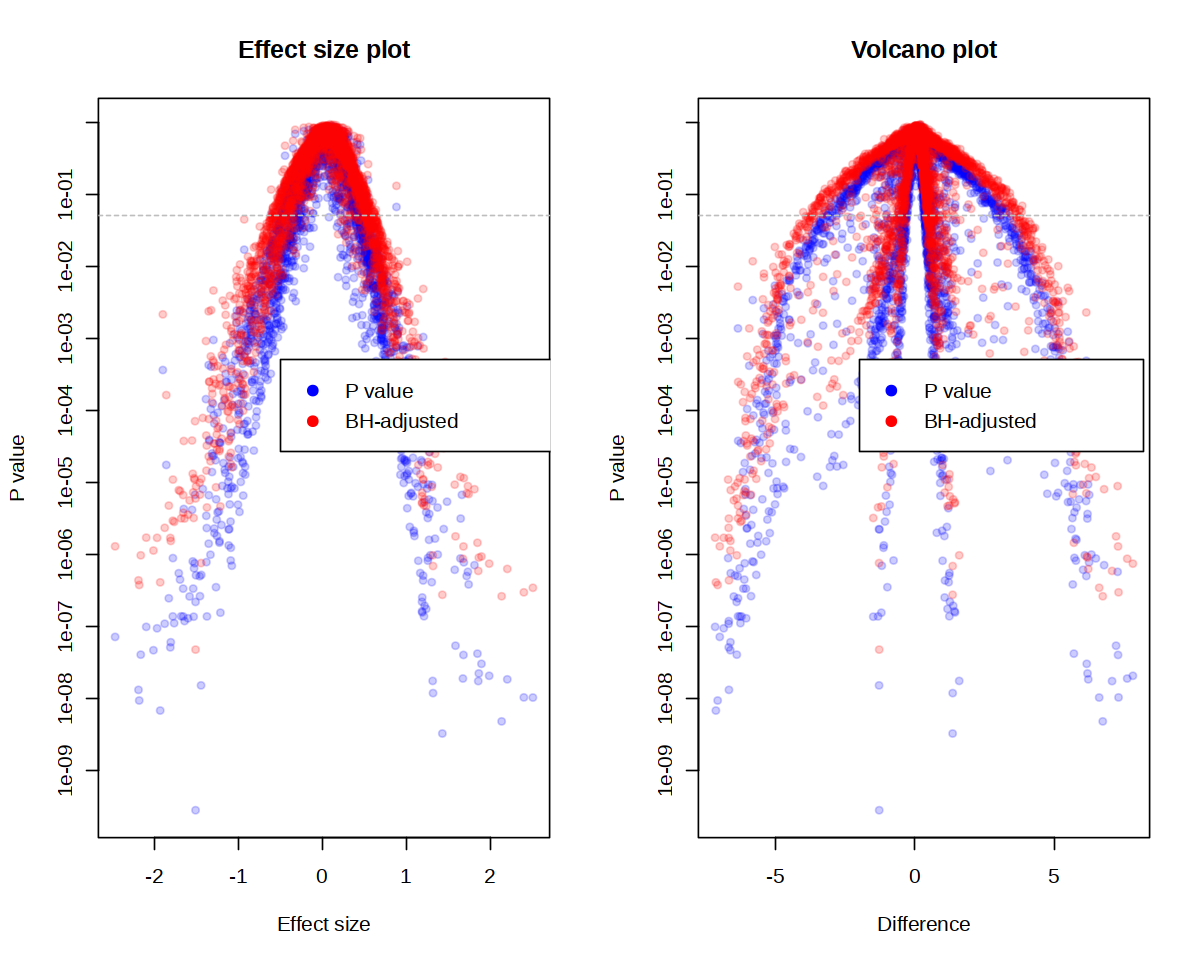

In [38]:
options(repr.plot.width=10, repr.plot.height=8)

# Effect size plot
par(mfrow=c(1,2))
plot(x.all$effect, 
    x.all$we.ep, 
    log="y", 
    cex=0.7, 
    col=rgb(0,0,1,0.2),  # Blue marks for expected P value of Welch’s t test
    pch=19, 
    xlab="Effect size", 
    ylab="P value", 
    main="Effect size plot")
points(x.all$effect, 
    x.all$we.eBH, 
    cex=0.7, 
    col=rgb(1,0,0,0.2), # Red marks for expected Benjamini-Hochberg corrected P value of Welch’s t test
    pch=19)
abline(h=0.05, lty=2, col="grey")
legend(-0.5,0.0005, legend=c("P value", "BH-adjusted"), pch=19, col=c("blue", "red"))

# Volcano plot
plot(x.all$diff.btw, 
    x.all$we.ep, 
    log="y", 
    cex=0.7, 
    col=rgb(0,0,1,0.2), # Blue marks for expected P value of Welch’s t test
    pch=19, 
    xlab="Difference", 
    ylab="P value", 
    main="Volcano plot")
points(x.all$diff.btw, 
    x.all$we.eBH, 
    cex=0.7, 
    col=rgb(1,0,0,0.2), # Red marks for expected Benjamini-Hochberg corrected P value of Welch’s t test
    pch=19)
abline(h=0.05, lty=2, col="grey")
legend(-2,0.0005, legend=c("P value", "BH-adjusted"), pch=19, col=c("blue", "red"))

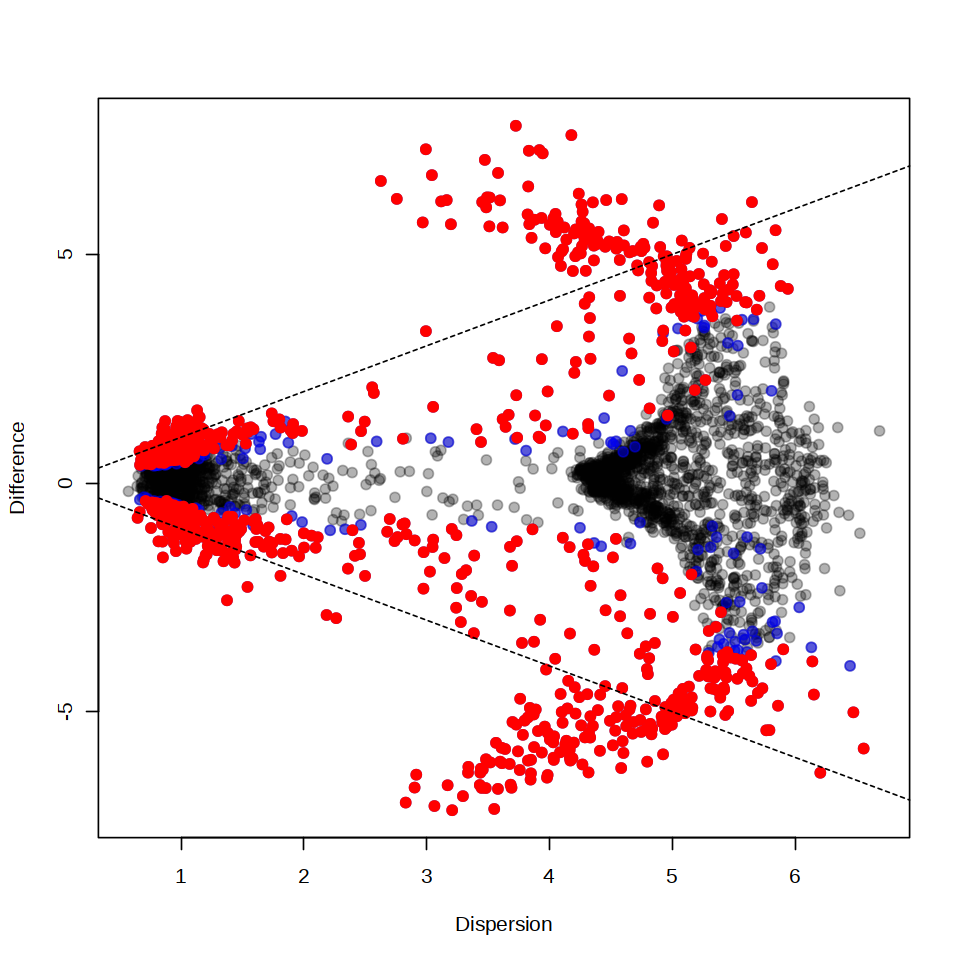

In [39]:
options(repr.plot.width=8, repr.plot.height=8)

found.by.all <- which(x.all$we.eBH < 0.05 & x.all$wi.eBH < 0.05)
found.by.one <- which(x.all$we.eBH < 0.05 | x.all$wi.eBH < 0.05)

plot(x.all$diff.win, x.all$diff.btw, pch=19, cex=1, col=rgb(0,0,0,0.3),
 xlab="Dispersion", ylab="Difference")
points(x.all$diff.win[found.by.one], x.all$diff.btw[found.by.one], pch=19,
 cex=1, col=rgb(0,0,1,0.5))
points(x.all$diff.win[found.by.all], x.all$diff.btw[found.by.all], pch=19,
 cex=1, col=rgb(1,0,0,1))
abline(0,1,lty=2)
abline(0,-1,lty=2)


In [40]:
kos_list = list()
for (index in found.by.one){
    current_ko = rownames(x.all)[index]
    kos_list = append(kos_list, current_ko)
}

In [41]:
ko_pathways = collect_pathways(kos_list)

In [42]:
head(ko_pathways)

[[1]]
[1] "map00521"

[[2]]
[1] "map00562"

[[3]]
[1] "map00020"

[[4]]
[1] "map00480"

[[5]]
[1] "map00720"

[[6]]
[1] "map04146"

In [43]:
pathways_counts = list()
for (path_element in ko_pathways) {
    if (path_element %in% names(pathways_counts)) {
        new_value = pathways_counts[[path_element]] + 1
        pathways_counts[path_element] = new_value       
    } else {
        pathways_counts[path_element] = 1 
    }
}

In [53]:
top_to_plot = names(tail(pathways_counts[order(unlist(pathways_counts))], 3))
top_to_plot

[1] "map00190" "map02010" "map02020"

In [54]:
for (p in top_to_plot) {
    nude_id =  gsub("map", "", p)
    pathview(gene.data = ko_matrix, 
        species = "ko", 
        pathway.id = nude_id, 
        both.dirs = TRUE, 
        low = c("#bd066b", "#bd066b"),  
        mid = c("#c9c9c9" , "#c9c9c9"), 
        high = c("#02b3ad" , "#02b3ad")
    )
}

Note: Only KEGG ortholog gene ID is supported, make sure it looks like "K01488"!

Note: Mapping via KEGG gene ID (not Entrez) is supported for this species,
it looks like "K01488"!

Info: Working in directory /home/jovyan/mgnify-examples/R Examples

Info: Writing image file ko00190.pathview.png

Info: some node width is different from others, and hence adjusted!

Note: Only KEGG ortholog gene ID is supported, make sure it looks like "K01488"!

Note: Mapping via KEGG gene ID (not Entrez) is supported for this species,
it looks like "K01488"!

Info: Working in directory /home/jovyan/mgnify-examples/R Examples

Info: Writing image file ko02010.pathview.png

Note: Only KEGG ortholog gene ID is supported, make sure it looks like "K01488"!

Note: Mapping via KEGG gene ID (not Entrez) is supported for this species,
it looks like "K01488"!

Info: Working in directory /home/jovyan/mgnify-examples/R Examples

Info: Writing image file ko02020.pathview.png

Info: some node width is different from 

In [55]:
if(!dir.exists("output_plots")){
    dir.create("output_plots")
    dir.create("output_plots/functions")
}

file.copy(from=list.files(pattern="./*pathview.png"), to="./output_plots/functions/", overwrite = TRUE)

png_files = list.files(path = ".", pattern = "*.png")
xml_files = list.files(path = ".", pattern = "*.xml")
files = c(png_files, xml_files)
unlink(files)

[1] TRUE TRUE TRUE TRUE TRUE

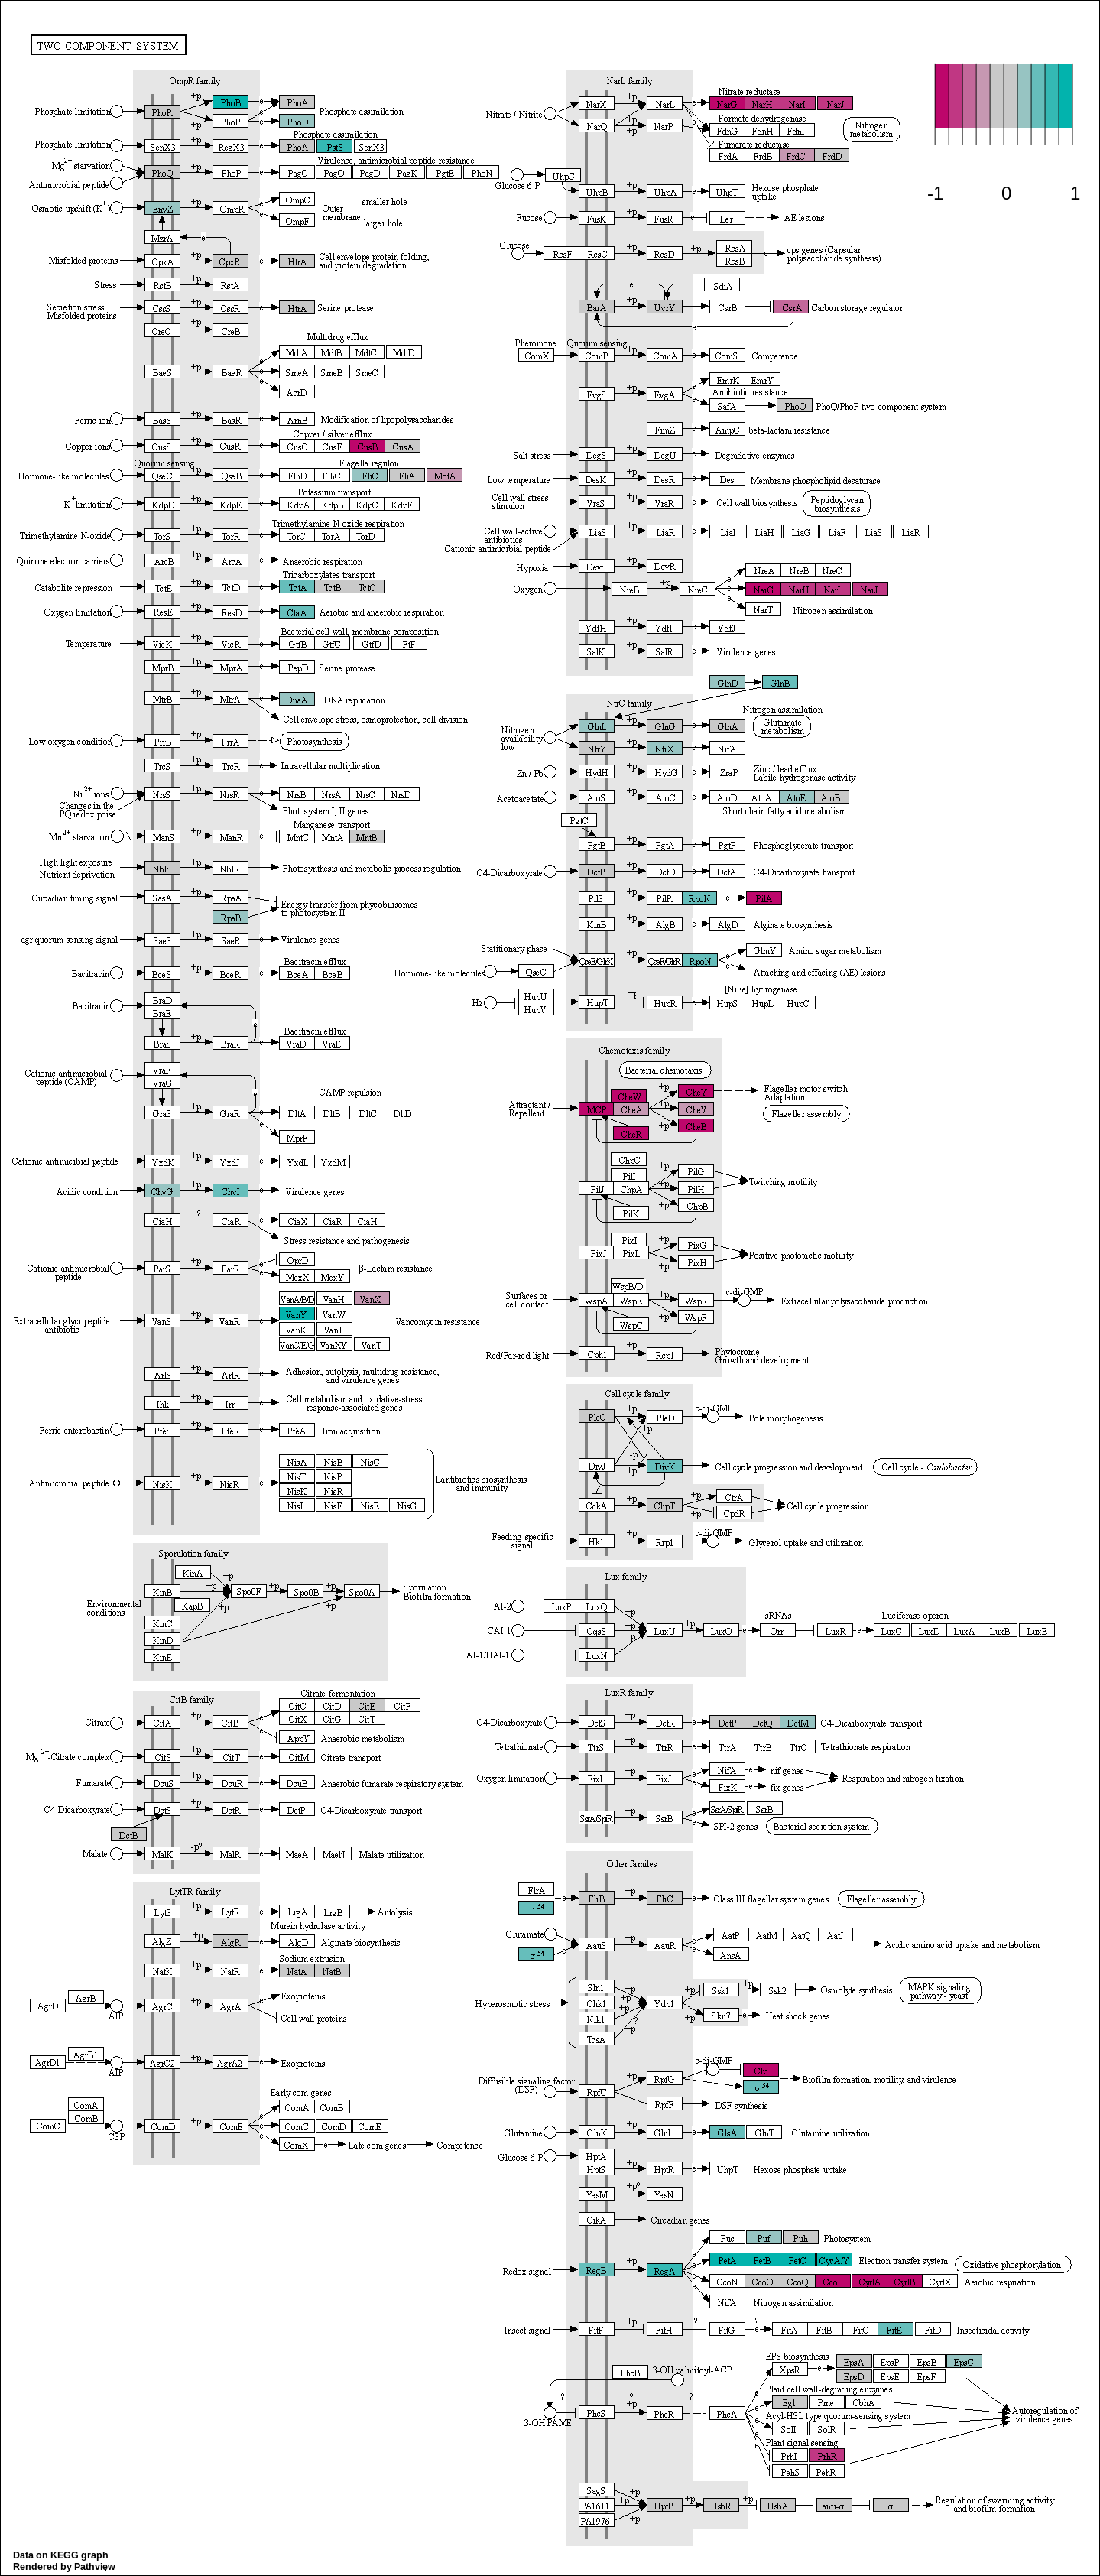

In [56]:
display_png(file='./output_plots/functions/ko02020.pathview.png')

 ### References: <a id='refs'/></a>

<a id="reference_1">1.</a> Lynch, M., Neufeld, J. Ecology and exploration of the rare biosphere. Nat Rev Microbiol 13:217–229 (2015) [DOI:10.1038/nrmicro3400](https://doi.org/10.1038/nrmicro3400)
    
<a id="reference_2">2.</a> McKnight, DT., Huerlimann, R., Bower, DS. et al. Methods for Normalizing Microbiome Data: An Ecological Perspective. Methods in Ecology and Evolution / British Ecological Society 10(3):389–400 (2019) [DOI:10.1111/2041-210X.13115](https://doi.org/10.1111/2041-210X.13115)

<a id="reference_3">3.</a> McMurdie, PJ., Holmes, S. Waste Not, Want Not: Why Rarefying Microbiome Data Is Inadmissible. PLoS Comput Biol 10(4):e1003531 (2014) [DOI:10.1371/journal.pcbi.1003531](https://doi.org/10.1371/journal.pcbi.1003531)

<a id="reference_4">4.</a> Willis, A. Rarefaction, Alpha Diversity, and Statistics. Front. Microbiol. Sec. Terrestrial Microbiology 10:2407 (2019) [DOI:10.3389/fmicb.2019.02407](https://doi.org/10.3389/fmicb.2019.02407)
    
<a id="reference_5">5.</a> Kim, BR., Shin, J., Guevarra, R. et al. Deciphering Diversity Indices for a Better Understanding of Microbial Communities. J Microbiol Biotechnol 28;27(12):2089-2093 (2017) [DOI:10.4014/jmb.1709.09027](https://doi.org/10.4014/jmb.1709.09027)

<a id="reference_6">6.</a> Wagner, BD., Grunwald, GK., Zerbe, GO. et al. On the Use of Diversity Measures in Longitudinal Sequencing Studies of Microbial Communities. Front. Microbiol. 9:1037 (2018) [DOI:10.3389/fmicb.2018.01037](https://doi.org/10.3389/fmicb.2018.01037)
    
<a id="reference_7">7.</a> Pereira, M., Wallroth, M., Jonsson, V. et al. Comparison of normalization methods for the analysis of metagenomic gene abundance data. BMC Genomics 19,274 (2018) [DOI:10.1186/s12864-018-4637-6](https://doi.org/10.1186/s12864-018-4637-6)
    
<a id="reference_8">8.</a> McMurdie, P., Holmes, S. Tutorial of 2018: The distance function in phyloseq. [Available at website](https://joey711.github.io/phyloseq/distance.html)

<a id="reference_9">9.</a> Wirbel, J., Zych, K., Essex, M. et al. Microbiome meta-analysis and cross-disease comparison enabled by the SIAMCAT machine learning toolbox. Genome Biol 22:93 (2021) [DOI:10.1186/s13059-021-02306-1](https://doi.org/10.1186/s13059-021-02306-1)
        
<a id="reference_10">10.</a> Tibshirani, R. Regression Shrinkage and Selection via the Lasso. Journal of the Royal Statistical Society. Series B (Methodological) 58(1):267-288 (1996) [DOI:10.1111/j.2517-6161.1996.tb02080.x](https://doi.org/10.1111/j.2517-6161.1996.tb02080.x)
    
Documentation and more MGnifyR code and exercises available [on GitHub](https://beadyallen.github.io/MGnifyR/) and [on rdrr site](https://rdrr.io/github/beadyallen/MGnifyR/f/vignettes/MGnifyR.Rmd)

Phyloseq tutorials available [on GitHub](https://joey711.github.io/phyloseq/index.html)
    
Visit the [SIAMCAT documentation](https://siamcat.embl.de/)
